<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_2/Aula_5_Manipulando_datas_e_gerando_novas_analises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 5
## Preparando conteúdo anterior

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from datetime import date

df = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/agendamento-hospitalar/main/dados/A160324189_28_143_208.csv", encoding = "ISO-8859-1",
                 skiprows = 3, sep = ";", skipfooter = 12,
                 thousands = ".", decimal = ",", engine = "python")
pd.options.display.float_format = "{:.2f}".format
use_col = df.mean().index.tolist()
use_col.insert(0, "Unidade da Federação")
use = df.loc[:,use_col]
use = use.set_index("Unidade da Federação")
use.sort_values(by = "Total") # crescente
total_ord = use.sort_values(by = "Total", ascending = False) # decrescente
total_ord = total_ord.drop("Total", axis = 1)
main_cols = total_ord.columns[6:]
total_ord = total_ord[main_cols]
total_ord = total_ord/1000000
total_ord.index = total_ord.index.str[3:] # Matar esse problema aqui de vez
ultimo_mes = total_ord.columns[-1]
gastos_ultimo_mes = total_ord[ultimo_mes]
gastos_prop_estado = gastos_ultimo_mes / gastos_ultimo_mes.sum()
tabelas_wiki = pd.read_html("https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o")
dados_populacao_raw = tabelas_wiki[0]
dados_populacao_raw

def limpeza(df1, df2):
  """limpeza, tratamento e join de dados"""
  df1 = df1.dropna().copy()
  df1.columns = ["posicao", "uf", "populacao", "porc", "pais"]
  df1.loc[:,"populacao"] = pd.to_numeric(df1.loc[:,"populacao"].str.replace(" ",""))
  df1 = df1.loc[:,["populacao", "uf"]]
  df1 = df1.set_index("uf")
  df1.index = df1.index.str.strip()

  for i in df2.index:
    df1.index = df1.index.str.replace(f"{i} {i}", i)

  return df1.join(df2)

gastos_e_populacao_recente = limpeza(dados_populacao_raw, gastos_ultimo_mes)

def insere_gastos_e_gasto_por_habitante_para(todos_os_gastos: pd.DataFrame, dados: pd.DataFrame, mes: str): 
  # mes: str define que o tipo de mes só pode ser string
  # pd.DataFrame para definir que só pode ser DataFrame
  gastos_do_mes = todos_os_gastos.loc[:,mes]
  dados.loc[:, f"gastos_{mes}"] = gastos_do_mes * 1000000
  dados.loc[:, f"gasto_por_habitante_{mes}"] = dados.loc[:, f"gastos_{mes}"] / dados.loc[:, "populacao"]

mensal = total_ord.T

# criando dicionario

meses = {
    "Jan" : 1,
    "Fev" : 2,
    "Mar" : 3,
    "Abr" : 4,
    "Mai" : 5,
    "Jun" : 6,
    "Jul" : 7,
    "Ago" : 8,
    "Set" : 9,
    "Out" : 10,
    "Nov" : 11,
    "Dez" : 12
}

def para_dia(ano_mes: str):
  ano: int = int(ano_mes[:4])
  mes: str = ano_mes[5:]
  mes_numero: int = meses[mes]
  return date(ano, mes_numero, 1)

mensal.index = mensal.index.map(para_dia)

mensal_aberto = mensal.reset_index().melt(id_vars = ["index"], value_vars = mensal.columns)
mensal_aberto.columns = ["mes", "uf", "gasto"]

Comparando ano a ano

In [2]:
mensal_aberto.columns = ["dia_mes_ano", "uf", "gasto"]
mensal_aberto.loc[:,"dia_mes_ano"] = mensal_aberto.loc[:,"dia_mes_ano"].astype("datetime64")
mensal_aberto.head()

,dia_mes_ano,uf,gasto
0,2008-02-01,São Paulo,172.83
1,2008-03-01,São Paulo,170.48
2,2008-04-01,São Paulo,170.28
3,2008-05-01,São Paulo,172.40
4,2008-06-01,São Paulo,175.42


In [3]:
mensal_aberto.loc[:,"dia_mes_ano"]

0      2008-02-01
1      2008-03-01
2      2008-04-01
3      2008-05-01
4      2008-06-01
          ...    
4045   2020-03-01
4046   2020-04-01
4047   2020-05-01
4048   2020-06-01
4049   2020-07-01
Name: dia_mes_ano, Length: 4050, dtype: datetime64[ns]

In [4]:
mensal_aberto.loc[:,"mes"] = mensal_aberto.loc[:,"dia_mes_ano"].dt.month
mensal_aberto.loc[:,"ano"] = mensal_aberto.loc[:,"dia_mes_ano"].dt.year
mensal_aberto.head()

,dia_mes_ano,uf,gasto,mes,ano
0,2008-02-01,São Paulo,172.83,2,2008
1,2008-03-01,São Paulo,170.48,3,2008
2,2008-04-01,São Paulo,170.28,4,2008
3,2008-05-01,São Paulo,172.40,5,2008
4,2008-06-01,São Paulo,175.42,6,2008


In [5]:
print(mensal_aberto.loc[:,"dia_mes_ano"][0])
print(mensal_aberto.loc[:,"dia_mes_ano"].head())

2008-02-01 00:00:00
0   2008-02-01
1   2008-03-01
2   2008-04-01
3   2008-05-01
4   2008-06-01
Name: dia_mes_ano, dtype: datetime64[ns]


In [6]:
print(mensal_aberto.query("uf == 'São Paulo'"))
print()
print("ou")
print()
print(mensal_aberto.loc[mensal_aberto.loc[:,"uf"] == "São Paulo"])

    dia_mes_ano         uf  gasto  mes   ano
0    2008-02-01  São Paulo 172.83    2  2008
1    2008-03-01  São Paulo 170.48    3  2008
2    2008-04-01  São Paulo 170.28    4  2008
3    2008-05-01  São Paulo 172.40    5  2008
4    2008-06-01  São Paulo 175.42    6  2008
..          ...        ...    ...  ...   ...
145  2020-03-01  São Paulo 276.61    3  2020
146  2020-04-01  São Paulo 251.70    4  2020
147  2020-05-01  São Paulo 302.86    5  2020
148  2020-06-01  São Paulo 299.06    6  2020
149  2020-07-01  São Paulo 282.71    7  2020

[150 rows x 5 columns]

ou

    dia_mes_ano         uf  gasto  mes   ano
0    2008-02-01  São Paulo 172.83    2  2008
1    2008-03-01  São Paulo 170.48    3  2008
2    2008-04-01  São Paulo 170.28    4  2008
3    2008-05-01  São Paulo 172.40    5  2008
4    2008-06-01  São Paulo 175.42    6  2008
..          ...        ...    ...  ...   ...
145  2020-03-01  São Paulo 276.61    3  2020
146  2020-04-01  São Paulo 251.70    4  2020
147  2020-05-01  São Paulo

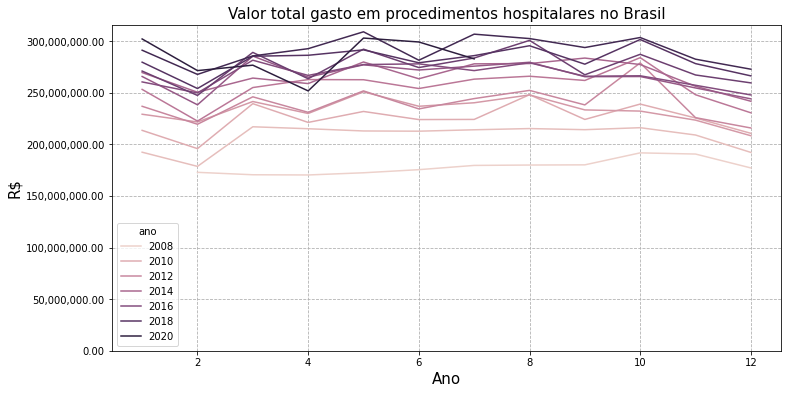

In [7]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(data = mensal_aberto.query("uf == 'São Paulo'"), x = "mes", y = "gasto", hue = "ano")
plt.title("Valor total gasto em procedimentos hospitalares no Brasil", fontsize = 15)
#ax.set_ylim(0)
plt.ylim(0)
#ax.legend(loc = "lower center", ncol = 6, bbox_to_anchor = (0.5,-0.5), fontsize = 12)
plt.ylabel("R$", fontsize = 15)
plt.xlabel("Ano", fontsize = 15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x*1000000)))
plt.grid(linestyle = "--")
plt.show()

In [8]:
dias_por_mes = {
    1 : 31,
    2 : 28,
    3 : 31,
    4 : 30,
    5 : 31,
    6 : 30,
    7 : 31,
    8 : 31,
    9 : 30,
    10 : 31,
    11 : 30,
    12 : 31
}

In [9]:
mensal_aberto.loc[:, "gasto_diario"] = mensal_aberto.loc[:, "gasto"] / mensal_aberto.loc[:,"mes"].map(dias_por_mes)

In [10]:
mensal_aberto.head()

,dia_mes_ano,uf,gasto,mes,ano,gasto_diario
0,2008-02-01,São Paulo,172.83,2,2008,6.17
1,2008-03-01,São Paulo,170.48,3,2008,5.50
2,2008-04-01,São Paulo,170.28,4,2008,5.68
3,2008-05-01,São Paulo,172.40,5,2008,5.56
4,2008-06-01,São Paulo,175.42,6,2008,5.85


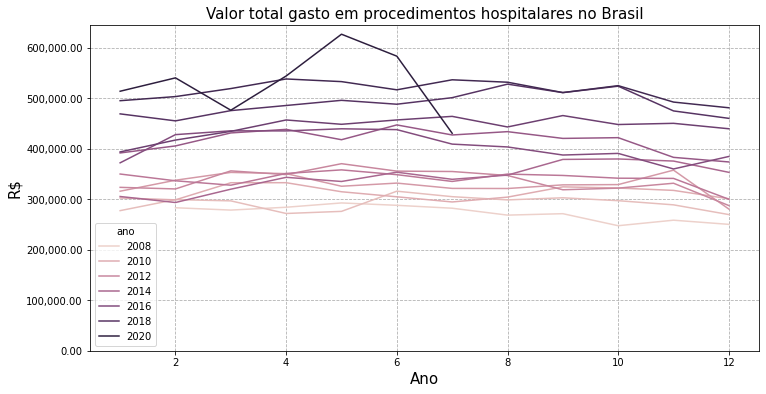

In [15]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(data = mensal_aberto.query("uf == 'Amazonas'"), x = "mes", y = "gasto_diario", hue = "ano")
plt.title("Valor total gasto em procedimentos hospitalares no Brasil", fontsize = 15)
plt.ylim(0)
#ax.legend(loc = "lower center", ncol = 6, bbox_to_anchor = (0.5,-0.5), fontsize = 12)
plt.ylabel("R$", fontsize = 15)
plt.xlabel("Ano", fontsize = 15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x*1000000)))
plt.grid(linestyle = "--")
plt.show()